# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 0.0005

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2024-01-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-10-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Agriculture' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    or ('Forex' in symbol.path)
    )
]

print(tickers)

intervals = [
    # mt5.TIMEFRAME_H8,
    # mt5.TIMEFRAME_H6,
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H3,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY', 'USDCAD', 'AUDUSD', 'AUDNZD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'CHFJPY', 'EURGBP', 'EURAUD', 'EURCHF', 'EURJPY', 'EURNZD', 'EURCAD', 'GBPCHF', 'GBPJPY', 'CADCHF', 'CADJPY', 'GBPAUD', 'GBPCAD', 'GBPNZD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'SPN35.cash', 'US2000.cash', 'N25.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'META', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
EURUSD
EURUSD
EURUSD
EURUSD
GBPUSD
GBPUSD
GBPUSD
GBPUSD
USDCHF
USDCHF
USDCHF
U

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16387: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16386: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16385: Timestamp('2024-10-23 01:00:00+0000', tz='UTC')}
2024-01-01 00:00:00+00:00
2024-10-01 00:00:00+00:00


In [7]:
from backbone.channel_strategy import Channel

STRATEGY = Channel

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16388
AAPL 16387
AAPL 16386
AAPL 16385
ADAUSD 16388
ADAUSD 16387
ADAUSD 16386
ADAUSD 16385
AIRF 16388
AIRF 16387
AIRF 16386
AIRF 16385
ALVG 16388
ALVG 16387
ALVG 16386
ALVG 16385
AMZN 16388
AMZN 16387
AMZN 16386
AMZN 16385
AUDCAD 16388
AUDCAD 16387
AUDCAD 16386
AUDCAD 16385
AUDCHF 16388
AUDCHF 16387
AUDCHF 16386
AUDCHF 16385
AUDJPY 16388
AUDJPY 16387
AUDJPY 16386
AUDJPY 16385
AUDNZD 16388
AUDNZD 16387
AUDNZD 16386
AUDNZD 16385
AUDUSD 16388
AUDUSD 16387
AUDUSD 16386
AUDUSD 16385
AUS200.cash 16388
AUS200.cash 16387
AUS200.cash 16386
AUS200.cash 16385
BABA 16388
BABA 16387
BABA 16386
BABA 16385
BAC 16388
BAC 16387
BAC 16386
BAC 16385
BAYGn 16388
BAYGn 16387
BAYGn 16386
BAYGn 16385
BTCUSD 16388
BTCUSD 16387
BTCUSD 16386
BTCUSD 16385
CADCHF 16388
CADCHF 16387
CADCHF 16386
CADCHF 16385
CADJPY 16388
CADJPY 16387
CADJPY 16386
CADJPY 16385
CHFJPY 16388
CHFJPY 16387
CHFJPY 16386
CHFJPY 16385
COCOA.c 16388
COCOA.c 16387
COCOA.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COCOA.c 16385
COFFEE.c 16388
COFFEE.c 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COFFEE.c 16386
COFFEE.c 16385
CORN.c 16388
CORN.c 16387
CORN.c 16386
CORN.c 16385
DASHUSD 16388
DASHUSD 16387
DASHUSD 16386
DASHUSD 16385
DBKGn 16388
DBKGn 16387
DBKGn 16386
DBKGn 16385
DOGEUSD 16388
DOGEUSD 16387
DOGEUSD 16386
DOGEUSD 16385
DOTUSD 16388
DOTUSD 16387
DOTUSD 16386
DOTUSD 16385
ETHUSD 16388
ETHUSD 16387
ETHUSD 16386
ETHUSD 16385
EU50.cash 16388
EU50.cash 16387
EU50.cash 16386
EU50.cash 16385
EURAUD 16388
EURAUD 16387
EURAUD 16386
EURAUD 16385
EURCAD 16388
EURCAD 16387
EURCAD 16386
EURCAD 16385
EURCHF 16388
EURCHF 16387
EURCHF 16386
EURCHF 16385
EURGBP 16388
EURGBP 16387
EURGBP 16386
EURGBP 16385
EURJPY 16388
EURJPY 16387
EURJPY 16386
EURJPY 16385
EURNZD 16388
EURNZD 16387
EURNZD 16386
EURNZD 16385
EURUSD 16388
EURUSD 16387
EURUSD 16386
EURUSD 16385
FRA40.cash 16388
FRA40.cash 16387
FRA40.cash 16386
FRA40.cash 16385
GBPAUD 16388
GBPAUD 16387
GBPAUD 16386
GBPAUD 16385
GBPCAD 16388
GBPCAD 16387
GBPCAD 16386
GBPCAD 16385
GBPCHF 16388
GBPCHF 16387
GBPCHF 16386
GBPCHF 16385
GB

In [9]:

rob_test = performance.groupby(['strategy', 'ticker']).agg({
    'return/dd': ['mean', 'std'],
    'stability_ratio': ['mean', 'std'],
    'trades': ['mean', 'std']
})

rob_test['return_dd_mean_std'] = rob_test[('return/dd', 'mean')] / rob_test[('return/dd', 'std')]


rob_test = rob_test[(rob_test[('return/dd', 'mean')] > 1) & (rob_test[('trades', 'mean')] > 10)].sort_values(by='return_dd_mean_std', ascending=False)

display(rob_test)

average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()

filter_performance = filter_performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

display(filter_performance.head(50))

return/dd           stability_ratio           trades  \
                      mean       std            mean       std   mean   
strategy ticker                                                         
Channel  AUDJPY   1.863251  0.565916        0.548249  0.079699  54.50   
         ETHUSD   1.596248  0.724376        0.579153  0.217619  79.75   
         BTCUSD   1.421003  0.674518        0.437032  0.276913  80.25   
         DOGEUSD  2.281619  1.221327        0.642220  0.146958  76.50   
         NZDJPY   1.482552  1.030997        0.327662  0.292992  55.00   
         EURCHF   1.996424  1.557773        0.612660  0.344560  46.75   
         NVDA     1.183643  1.100670        0.617788  0.230780  11.25   
         GBPCHF   2.581792  2.691225        0.464794  0.322924  47.50   
         WMT      1.273636  1.561375        0.310464  0.331032  14.25   

                            return_dd_mean_std  
                        std                     
strategy ticker                                 
Channel  AUDJPY   43.431939           3.292453  
         ETHUSD   55.560028           2.203619  
         BTCUSD   55.271301           2.106696  
         DOGEUSD  51.752617           1.868147  
         NZDJPY   40.298883           1.437979  
         EURCHF   41.339045           1.281589  
         NVDA     10.688779           1.075384  
         GBPCHF   41.972213           0.959337  
         WMT      10.719919           0.815714

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,Channel,AUDJPY,16385,0.540720,117,46.033084,42.177437,1.091415,5.086206,30.769231,0.033019,241 days 23:00:00
0,Channel,AUDJPY,16386,0.492463,49,77.981353,40.645130,1.918590,7.325343,30.612245,0.146566,241 days 22:00:00
0,Channel,AUDJPY,16387,0.496593,33,68.514884,34.394330,1.992040,6.826183,33.333333,0.189412,241 days 21:00:00
0,Channel,AUDJPY,16388,0.663221,19,66.682381,27.206634,2.450960,7.082113,36.842105,0.334129,241 days 20:00:00
0,Channel,BTCUSD,16385,0.719325,158,22.267679,14.963760,1.488107,7.070561,31.012658,0.033558,243 days 23:00:00
0,Channel,BTCUSD,16386,0.476910,78,26.323457,13.476828,1.953238,7.945040,30.769231,0.270277,244 days 00:00:00
0,Channel,BTCUSD,16387,0.055871,54,7.924575,17.554367,0.451430,1.711533,25.925926,-0.129448,244 days 00:00:00
0,Channel,BTCUSD,16388,0.496021,31,18.041015,10.071814,1.791238,5.647258,32.258065,0.402604,244 days 00:00:00
0,Channel,DOGEUSD,16385,0.741484,152,54.925833,17.842699,3.078337,14.663557,26.973684,0.260259,243 days 23:00:00
0,Channel,DOGEUSD,16386,0.790559,68,35.354396,9.972893,3.545049,13.642189,30.882353,0.410032,244 days 00:00:00


In [10]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    break
    

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [11]:
lookback_bars_per_interval = {
    15: 2000,
    16385: 2000,
    16386: 1800,
    16387: 1800,
    16388: 1200,
    16390: 1200,
    16392: 1200,
}

In [12]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars =  200

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'sma_period' : list(np.arange(9, 24, 3)),
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
        
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

AUDJPY 16385
AUDJPY 16386
AUDJPY 16387
AUDJPY 16388
BTCUSD 16385
BTCUSD 16386
BTCUSD 16387
BTCUSD 16388
DOGEUSD 16385
DOGEUSD 16386
DOGEUSD 16387
DOGEUSD 16388
ETHUSD 16385
ETHUSD 16386
ETHUSD 16387
ETHUSD 16388
EURCHF 16385
EURCHF 16386
EURCHF 16387
EURCHF 16388
GBPCHF 16385
GBPCHF 16386
GBPCHF 16387
GBPCHF 16388
NVDA 16385
NVDA 16386
NVDA 16387
NVDA 16388
NZDJPY 16385
NZDJPY 16386
NZDJPY 16387
NZDJPY 16388
WMT 16385
WMT 16386
WMT 16387
WMT 16388


In [13]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        params = all_opt_params[ticker][interval]
        prices = symbols[ticker][interval].iloc[lookback_bars - warmup_bars + 1:]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AUDJPY 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AUDJPY 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AUDJPY 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AUDJPY 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BTCUSD 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BTCUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BTCUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BTCUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


EURCHF 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


EURCHF 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


EURCHF 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


EURCHF 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GBPCHF 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GBPCHF 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GBPCHF 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GBPCHF 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NVDA 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NVDA 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NVDA 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NVDA 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NZDJPY 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NZDJPY 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NZDJPY 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NZDJPY 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WMT 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WMT 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WMT 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WMT 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [21]:

rob_test = performance.groupby(['strategy', 'ticker']).agg({
    'return/dd': ['mean', 'std'],
    'stability_ratio': ['mean', 'std'],
    'trades': ['mean', 'std']
})

rob_test['return_dd_mean_std'] = rob_test[('return/dd', 'mean')] / rob_test[('return/dd', 'std')]

rob_test = rob_test[(rob_test[('return/dd', 'mean')] > 1) & (rob_test[('trades', 'mean')] > 10)].sort_values(by='return_dd_mean_std', ascending=False)

display(rob_test)

average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()

filter_performance = filter_performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

display(filter_performance.head(50))

return/dd           stability_ratio            trades  \
                     mean       std            mean       std    mean   
strategy ticker                                                         
Channel  BTCUSD  6.455572  1.816754        0.882482  0.050507  468.25   
         NVDA    3.893179  2.305810        0.777923  0.227008   54.00   
         ETHUSD  2.844009  2.122072        0.451573  0.304055  463.50   

                            return_dd_mean_std  
                        std                     
strategy ticker                                 
Channel  BTCUSD  311.394043           3.553356  
         NVDA     49.443571           1.688422  
         ETHUSD  300.894777           1.340204

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,Channel,BTCUSD,16385,0.814666,901,125.005217,26.813459,4.662032,30.582759,27.746948,-0.001435,1022 days 02:00:00
0,Channel,BTCUSD,16386,0.916239,483,151.070549,17.970777,8.406456,49.229980,32.298137,0.122767,980 days 04:00:00
0,Channel,BTCUSD,16387,0.925342,285,131.505102,17.362428,7.574120,40.506179,29.824561,0.093261,936 days 18:00:00
0,Channel,BTCUSD,16388,0.873680,204,67.171717,12.968312,5.179681,25.597633,32.352941,0.180394,894 days 16:00:00
0,Channel,ETHUSD,16385,0.838779,886,159.546689,26.563473,6.006243,39.290338,29.909707,0.119062,1022 days 02:00:00
0,Channel,ETHUSD,16386,0.119813,461,55.216622,36.996327,1.492489,8.916261,30.585683,0.152292,980 days 04:00:00
0,Channel,ETHUSD,16387,0.334920,303,38.109206,21.283969,1.790512,9.777046,29.372937,0.124904,936 days 18:00:00
0,Channel,ETHUSD,16388,0.512781,204,44.814302,21.475213,2.086792,10.613780,31.862745,0.200407,894 days 16:00:00
0,Channel,NVDA,16385,0.936722,120,62.993830,9.759903,6.454350,28.076946,40.833333,0.711937,856 days 03:00:00
0,Channel,NVDA,16386,0.857900,61,33.384606,8.950028,3.730112,13.847474,40.983607,0.856567,701 days 00:00:00


In [23]:
filtered_wfo_performance = performance[
    (
        ((performance['ticker'] == 'NVDA') & (performance['interval'] == 16385))
        | ((performance['ticker'] == 'BTCUSD') & (performance['interval'] == 16386))
        | ((performance['ticker'] == 'ETHUSD') & (performance['interval'] == 16385))
    )
].sort_values(by='custom_metric', ascending=False).drop_duplicates(subset=['ticker'], keep='first')

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Channel,BTCUSD,16386,0.916239,151.070549,25107.054937,17.970777,208 days 00:00:00,32.298137,0.986681,483,0.122767,55.541159,25107.054937,980 days 04:00:00,8.406456,49.229980
0,Channel,ETHUSD,16385,0.838779,159.546689,25954.668888,26.563473,257 days 00:00:00,29.909707,0.752743,886,0.119062,54.023468,25954.668888,1022 days 02:00:00,6.006243,39.290338
0,Channel,NVDA,16385,0.936722,62.993830,16299.383024,9.759903,213 days 20:00:00,40.833333,1.215768,120,0.711937,54.485777,16299.383024,856 days 03:00:00,6.454350,28.076946


# Montecarlo

In [24]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    try:
        
        print(f"Procesando ticker: {ticker} {interval}")
        trades_history = wfo_stats_per_symbol[ticker][interval]._trades
        eq_curve = wfo_stats_per_symbol[ticker][interval]._equity_curve
        
        # Simulación de Montecarlo para cada ticker (datos agregados)
        mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
            equity_curve=eq_curve,
            trade_history=trades_history, 
            n_simulations=100_000, 
            initial_equity=INITIAL_CASH, 
            threshold_ruin=0.9, 
            return_raw_curves=True,
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        
        montecarlo_simulations[f"{ticker}_{interval}"] = mc
        
        synthetic_drawdown_curve["ticker"] = f"{ticker}_{interval}"
        synthetic_return_curve["ticker"] = f"{ticker}_{interval}"
        
        all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
        all_returns = pd.concat([all_returns, synthetic_return_curve])
    
    except Exception as e:
        print(f'hubo un problema con {ticker}_{interval}: {e}')

Procesando ticker: BTCUSD 16386
Procesando ticker: ETHUSD 16385
Procesando ticker: NVDA 16385


In [25]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_BTCUSD_16386,drawdown_ETHUSD_16385,drawdown_NVDA_16385
count,100000.000000,100000.000000,100000.000000
mean,-36.820704,-42.966604,-14.638845
std,10.488029,11.357837,5.320441
min,-89.249455,-89.580943,-54.531129
10%,-51.258576,-58.784967,-21.818978
25%,-43.063846,-50.077335,-17.434031
50%,-35.290267,-41.430558,-13.641765
75%,-29.049798,-34.513633,-10.790479
90%,-24.645104,-29.486655,-8.849910
max,-12.603711,-15.887342,-3.732458


,return_BTCUSD_16386,return_ETHUSD_16385,return_NVDA_16385
count,100000.000000,100000.000000,100000.000000
mean,195.205085,223.832112,70.225129
std,199.834576,264.256880,44.173538
min,-88.711537,-82.374034,-50.294076
10%,10.576895,0.070462,18.572914
25%,61.756315,54.744289,38.709095
50%,144.401111,150.322926,64.794693
75%,269.533934,307.864021,95.843322
90%,438.949075,528.025586,128.501777
max,2958.752339,4306.477839,369.903427


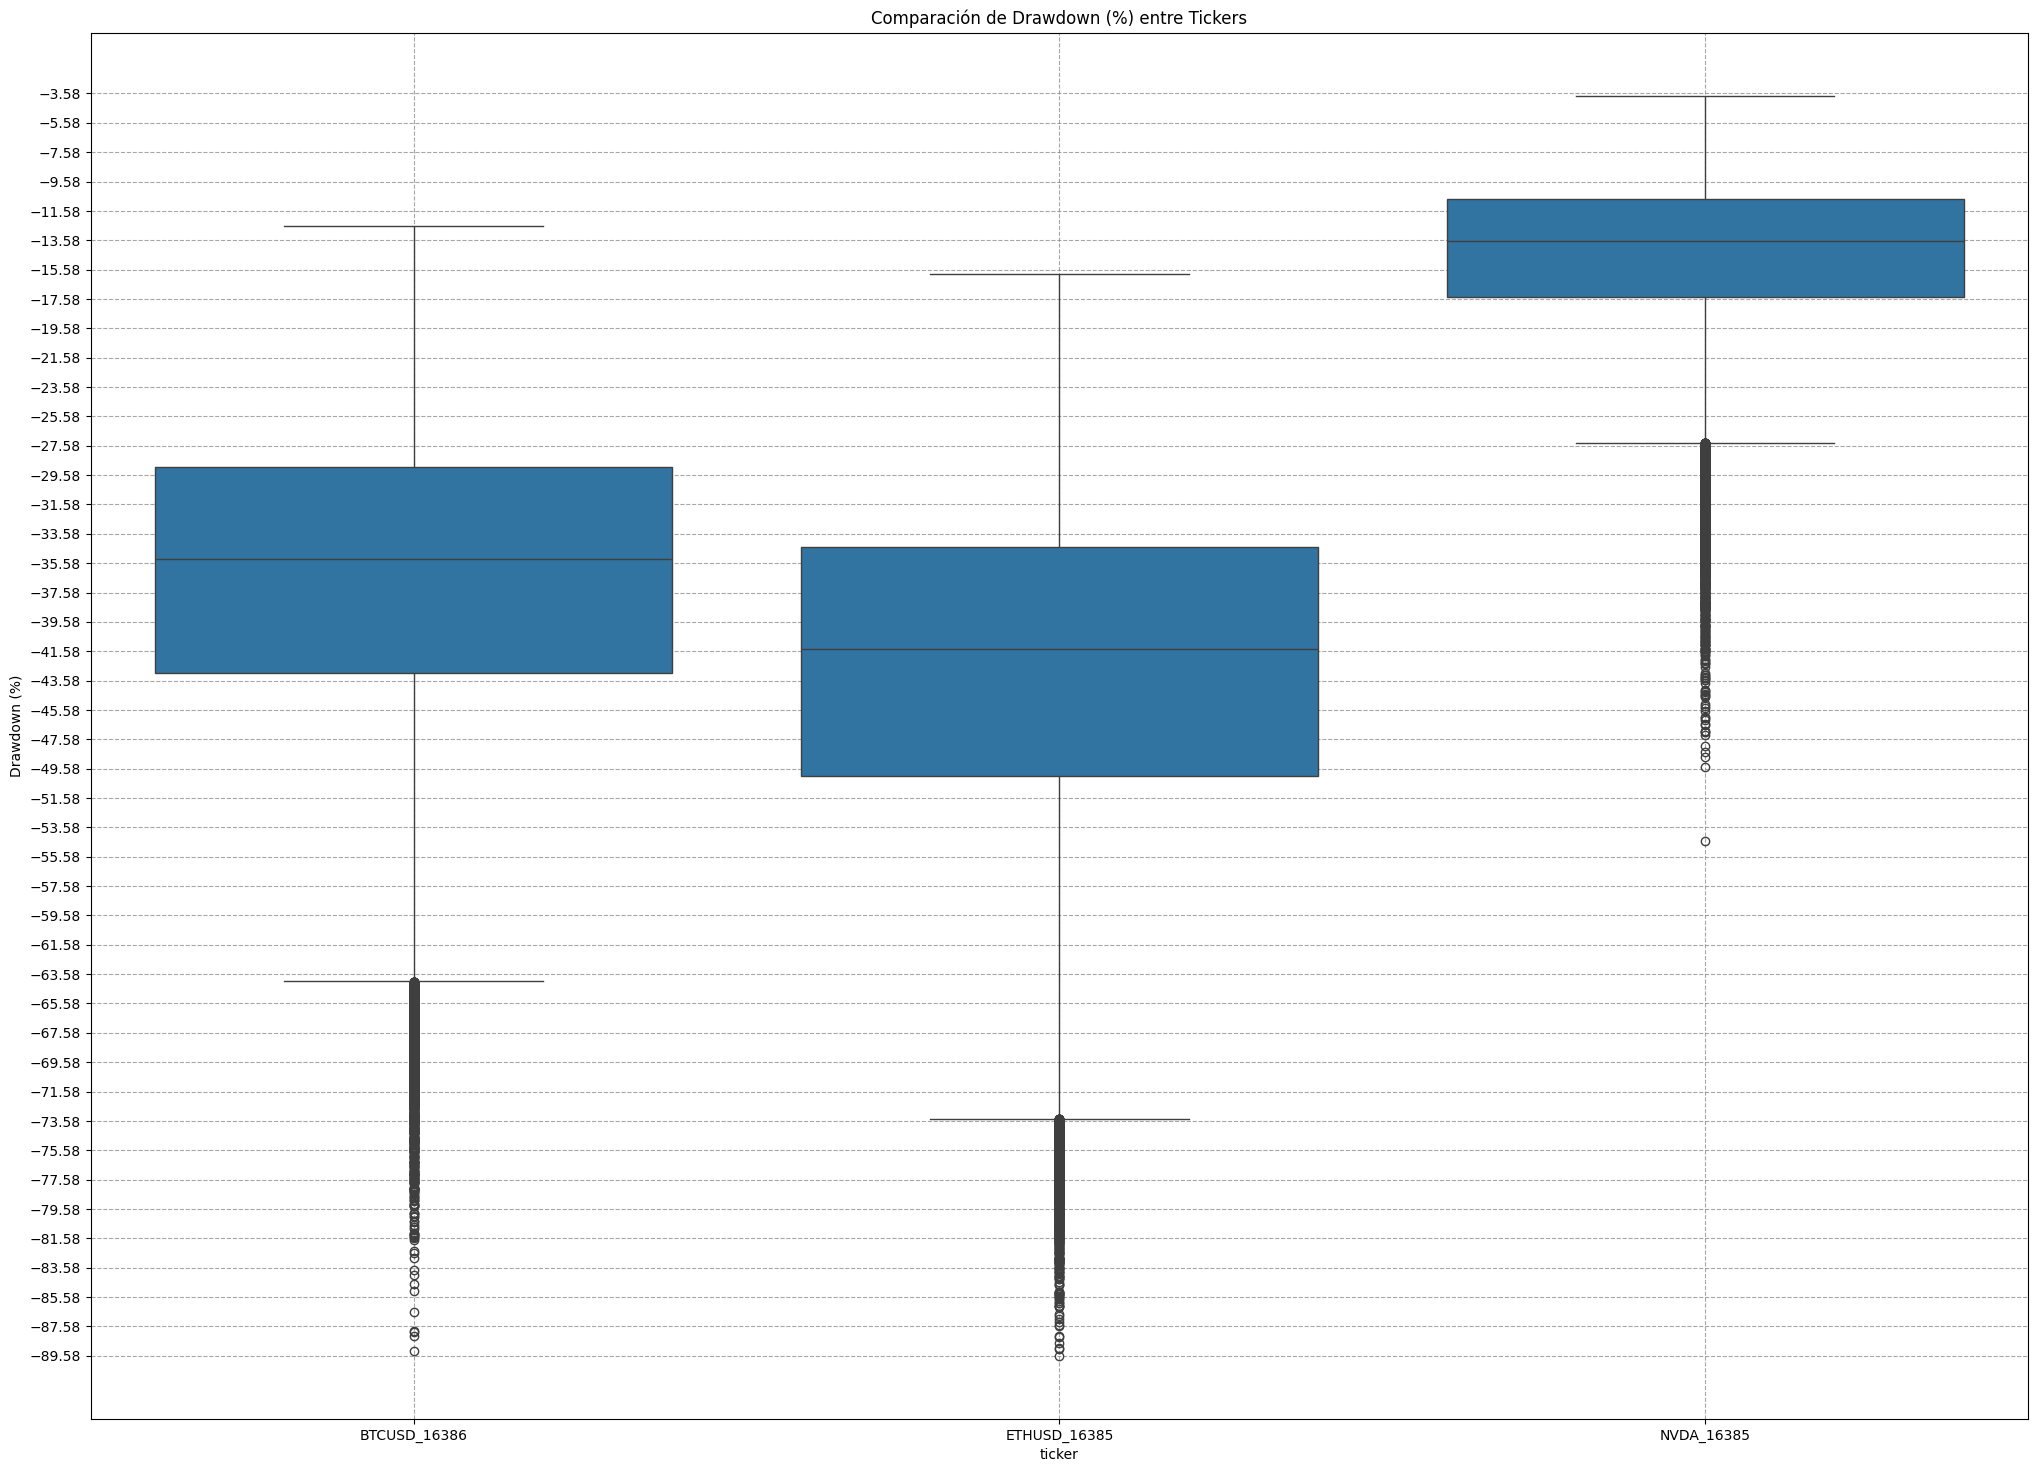

In [26]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


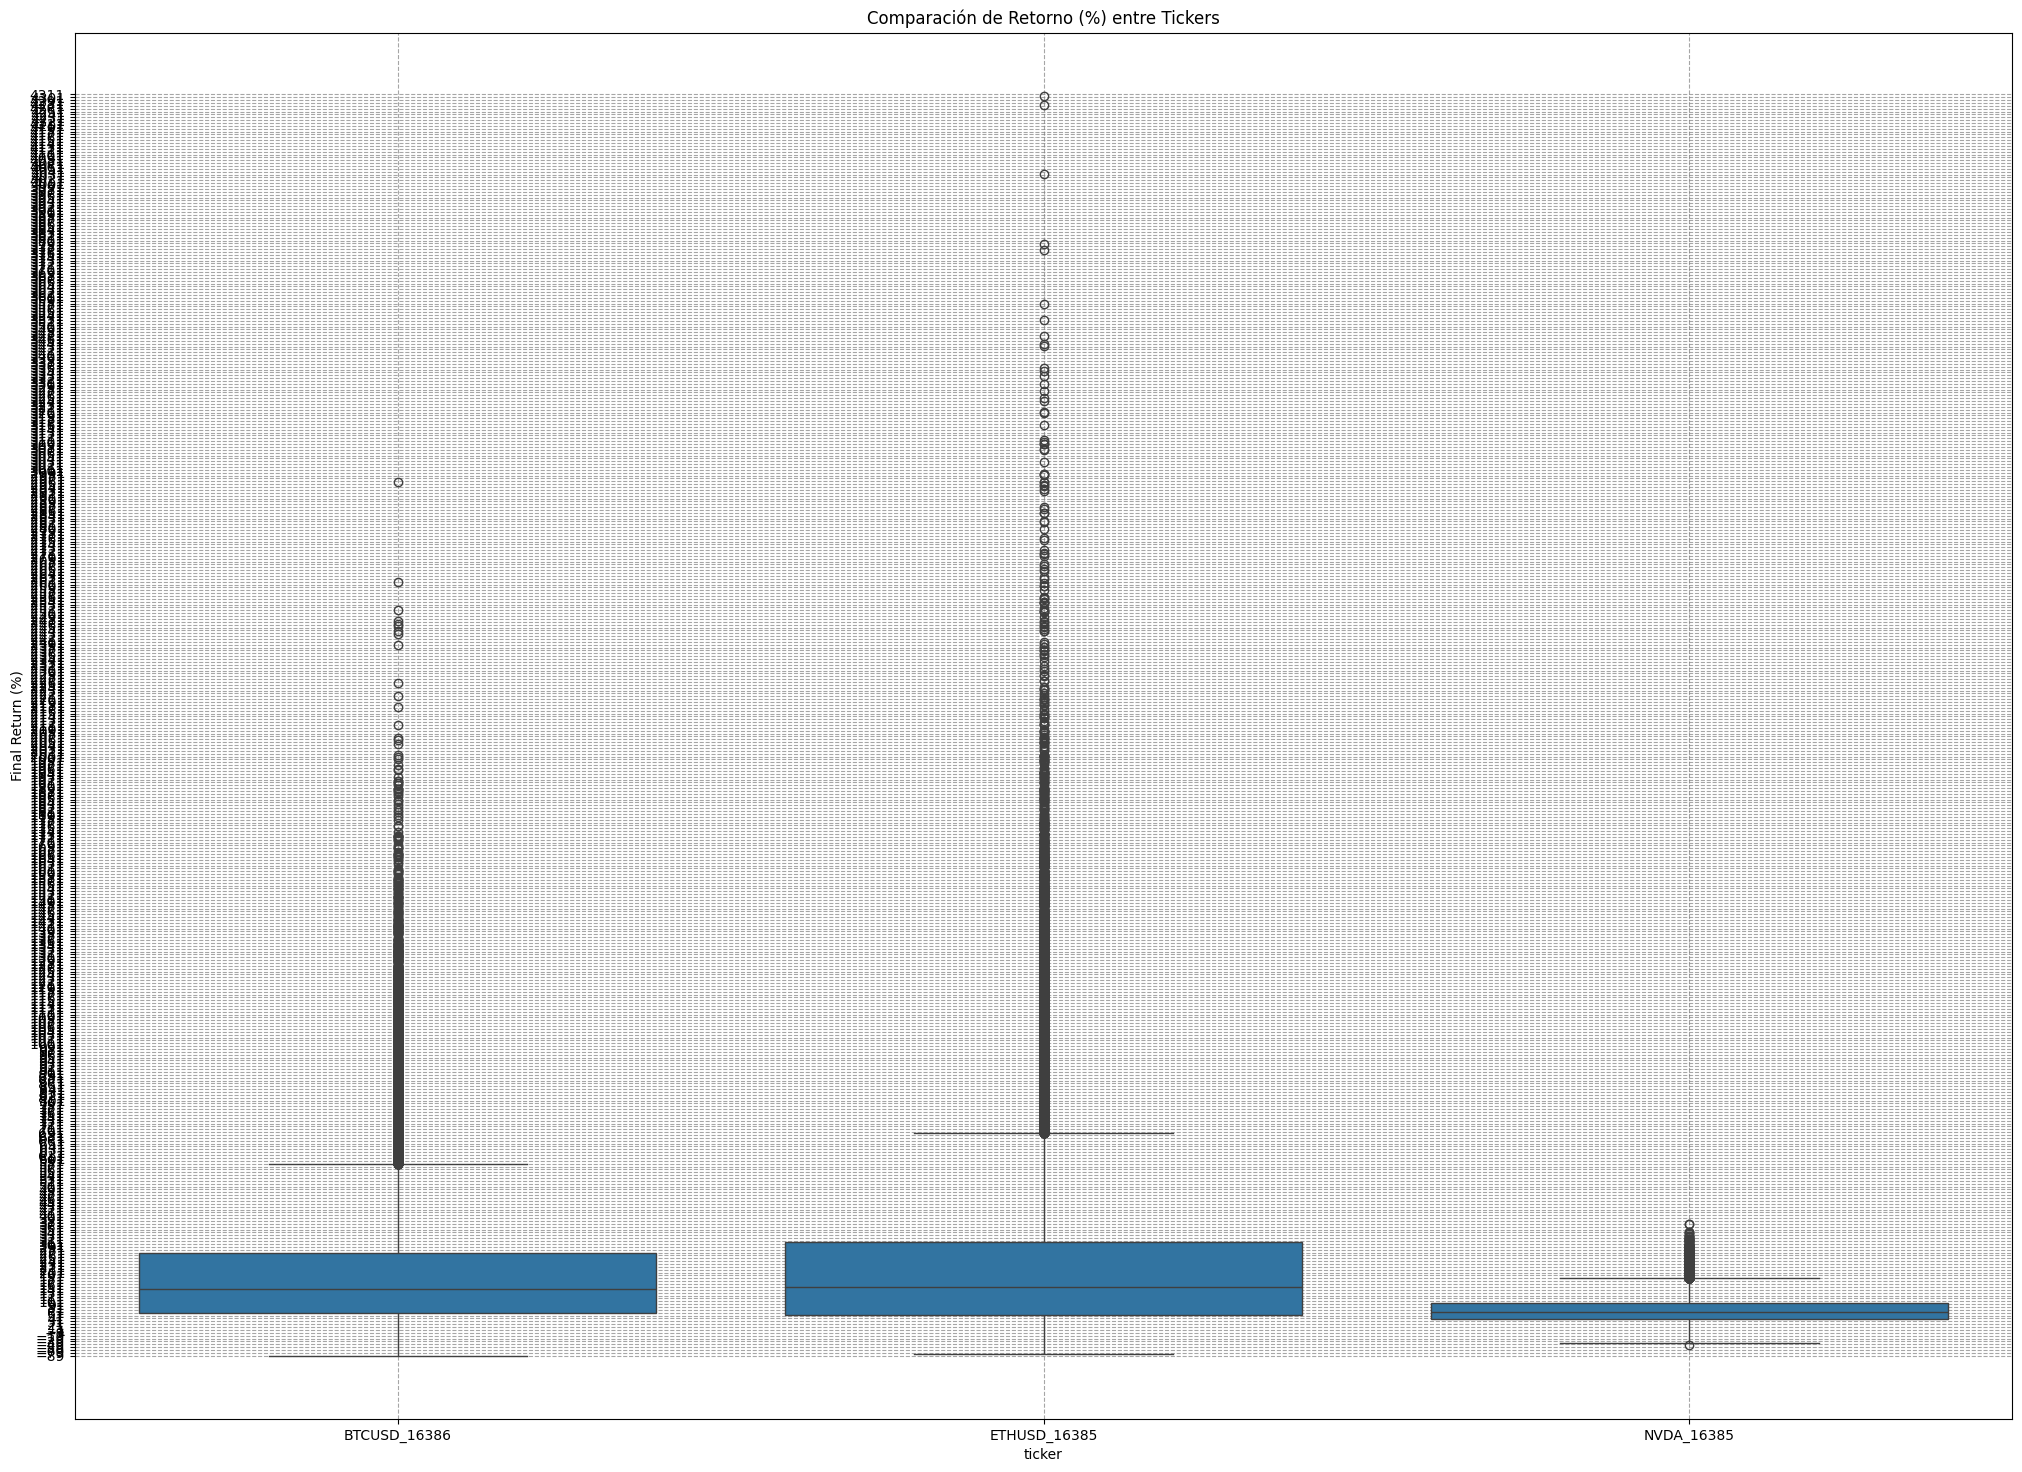

In [27]:
# Generar el gráfico
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
